# How to compute Hessian-inverse-vector products

This demo solves the linear system $Hx = g$ where $H$ is the Hessian of a deep
net and $g$ is the vector of gradients of the deep net on a batch. This
direction is the preconditioned descent direction.

We'll compare the brute-force way of computing the direction: 1) by computing
$H$ and storing $H$ using autograd, then solving the resulting dense system, and
2) using the Hessian-inverse-product described in the paper.

## Build the deep net

Create a 20 layer deep net. The code supports artbitrary layers, but for this
demo, we'll use a sequence of dense blocks.

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import hessian
import block_partitioned_matrices as bpm

input_dim = 5
num_classes = 3
batch_size = 1

model = hessian.SequenceOfDenseBlocks(
    input_dim=input_dim,
    hidden_dim=10,
    num_classes=num_classes,
    num_layers=20,
    activation=torch.tanh,
)

## Generate a batch of random input and target.

In [3]:
z_in = torch.randn(batch_size, input_dim, requires_grad=True)
target = torch.randint(0, num_classes, (batch_size,))

## Compute the gradient

Compute the derivative of the loss with respect to the parameters. To stay
consistent with the notation of the paper, the loss is baked into the last layer
of the model.

Then gather the gradients into a block-partitioned vector.

In [4]:
loss = model(z_in, target)
loss.backward()

stacked_gradients = bpm.Vertical(
    param.grad.reshape(-1, 1) for _, param in model.named_parameters()
)

## Hessian-inverse-product the traditional way

Apply the inverse of the Hessian to the gradient the traditional way, using
torch.func.hessian and a dense linear solver.

In [18]:
hessian_damping = 1e-3

def loss_fn(params):
    return torch.func.functional_call(model, params, (z_in, target))


H = hessian.flatten_2d_pytree(
    torch.func.hessian(loss_fn)(dict(model.named_parameters()))
)
print(f"Condition number of H: {torch.linalg.cond(H):.2e}")
print(
    f"Condition number of H+epsilon*I: {torch.linalg.cond(H + hessian_damping * torch.eye(H.shape[0])):.2e}"
)

hinv_g_torch = torch.linalg.solve(
    H + hessian_damping * torch.eye(H.shape[0]), stacked_gradients.to_tensor()
)

Condition number of H: 2.44e+08
Condition number of H+epsilon*I: 1.34e+02


## Hessian-inverse-product the proposed way

Apply the inverse of the Hessian to the gradient the proposed way: write the
Hessian as a polynomial, lift and pivot it to a tri-diagonal form, factorize it
LDU form, then use backsubtitution and a forward substitution to solve $Hx = g$.

In [19]:
hinv_g = model.hessian_inverse_product(
    z_in, target, stacked_gradients, hessian_damping
).to_tensor()

# Compare the results

Max absolute difference: 4.04e-02


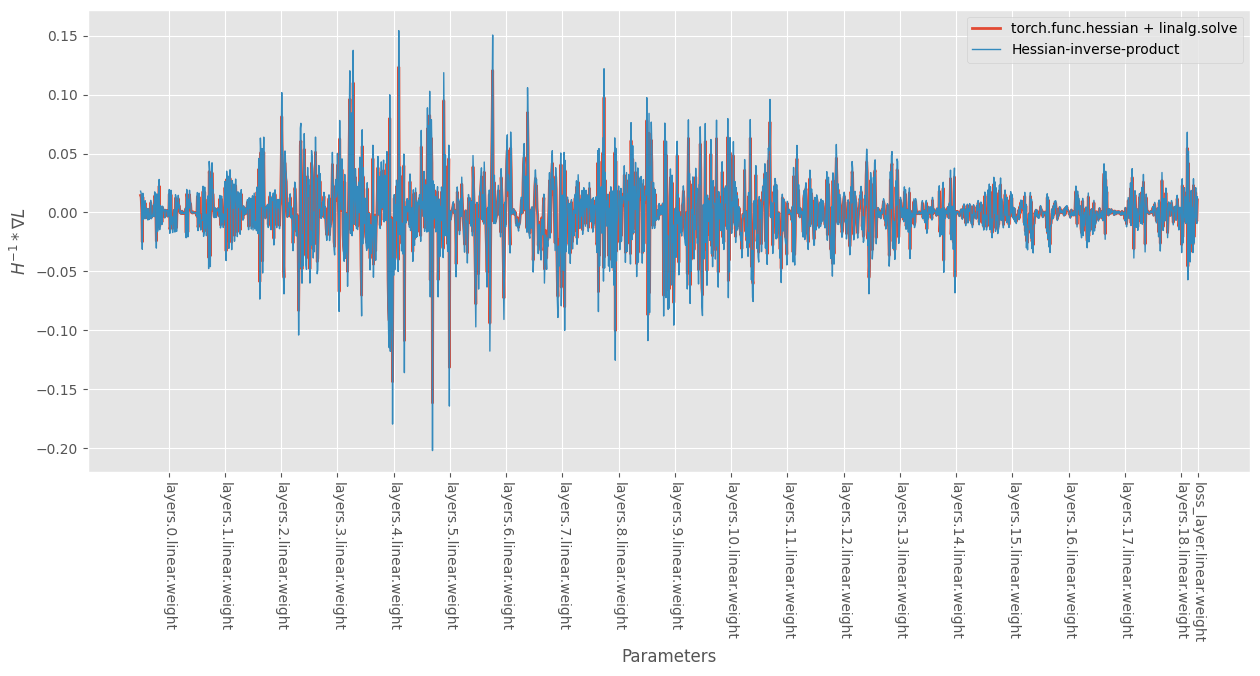

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(hinv_g_torch.detach().numpy(), lw=2, label="torch.func.hessian + linalg.solve")
plt.plot(hinv_g.detach().numpy(), lw=1, label="Hessian-inverse-product")
plt.legend()
plt.xlabel("Parameters")
plt.ylabel(r"$H^{-1} * \nabla L$")
plt.xticks(
    np.cumsum([param.numel() for _, param in model.named_parameters()]),
    [name for name, _ in model.named_parameters()],
    rotation=-90,
)

print(f"Max absolute difference: {(hinv_g - hinv_g_torch).abs().max().item():.2e}")